# Dataset Information

## Important definitions

**Lesion:** a region in an organ or tissue which has suffered damage through injury or disease, such as a wound, ulcer, abscess, or tumour.

## Types of Tumors:

**1. Necrotic and Non-Enhancing Tumor Core:** (Label=1)

- **Necrotic Core:** This refers to the dead or dying cells at the center of the tumor. The necrosis occurs due to the rapid growth of the tumor, which outstrips its blood supply, leading to a lack of oxygen and nutrients. On MRI, the necrotic core typically appears as a darker, non-enhancing area within the tumor on T1-weighted post-contrast images because it does not take up the contrast agent.

- **Non-Enhancing Tumor Core:** This includes the necrotic core and may also include other parts of the tumor that do not show an uptake of the contrast agent on T1-weighted post-contrast images. These non-enhancing regions can be made up of inactive or less active tumor cells, and they do not have the disrupted blood-brain barrier that is characteristic of more active tumor regions.

**2. Peritumoral Edema:** (Label=2)

- This refers to the swelling or accumulation of fluid around the tumor. Edema occurs as a result of the tumor's growth disrupting the normal functioning of the brain's blood vessels, leading to leakage of fluid into the surrounding brain tissue. On T2-weighted MRI scans, edema appears as a hyperintense (brighter) area surrounding the tumor. It's important to differentiate peritumoral edema from the tumor itself because it represents a reaction of the brain to the presence of the tumor rather than the tumor tissue.

**3. Enhancing Tumor:** (Label=4)

- This term describes the portion of the tumor that shows uptake of the contrast agent on T1-weighted post-contrast MRI scans. The enhancing tumor is typically considered to be the active, growing part of the tumor. The contrast agent (usually gadolinium-based) leaks through the disrupted blood-brain barrier in these areas, making them appear brighter on post-contrast images. The pattern and extent of enhancement can provide important diagnostic and prognostic information. In high-grade gliomas, such as glioblastoma, the enhancing portion often surrounds the necrotic core and is indicative of aggressive tumor behavior.

## About this Dataset

Each example contains 5 files. The first 4 files are variations of the MRI scan, providing varied information about the subject brain. The last file is the segmentation mask, which we are trying to predict.

1. `BraTS20_Training_***_flair.nii`: This is the FLAIR (Fluid Attenuated Inversion Recovery) MRI image. FLAIR is particularly good at highlighting lesions or abnormalities in the white matter of the brain.

2. `BraTS20_Training_***_t1.nii`: This is the T1-weighted MRI scan without contrast enhancement. T1 scans provide good anatomical detail and are particularly good at visualizing the gray matter of the brain.

3. `BraTS20_Training_***_t1ce.nii`: This is the T1-weighted MRI scan with contrast enhancement (CE), typically using a gadolinium-based contrast agent. The contrast enhancement helps to highlight regions of the brain where the blood-brain barrier is disrupted, which is common in active tumor areas.

4. `BraTS20_Training_***_t2.nii`: This is the T2-weighted MRI scan. T2 scans are good at visualizing fluid-filled spaces in the brain, and they provide complementary information to T1-weighted scans, especially for detecting edema and differentiating it from the tumor.

5. `BraTS20_Training_***_seg.nii`: This file contains the segmentation masks for the tumor regions. The segmentation contains pixel values in [0, 1, 2, 4], representing the 4 classes being segmented:
    - 0: Background
    - 1: Necrotic and Non-Enhancing Tumor Core
    - 2: Peritumoral Edema
    - 4: Enhancing Tumor

## Details about Scans

### FLAIR

In the dataset:
- `BraTS20_Training_***_flair.nii` - FLAIR MRI scan

FLAIR (Fluid Attenuated Inversion Recovery) is a special MRI imaging technique used to highlight the fluids in the brain and spinal cord. It is particularly useful for detecting lesions or areas of abnormality within the white matter.

### T1

In the dataset:
- `BraTS20_Training_***_t1.nii` - T1 MRI scan
- `BraTS20_Training_***_t1ce.nii` - T1 MRI scan with contrast enhancement

A T1-weighted MRI scan is a type of magnetic resonance imaging (MRI) that provides high-resolution images of the body's internal structures, with a particular emphasis on the contrast between different tissues based on their T1 relaxation times. In MRI, the term "T1" refers to the longitudinal relaxation time, which is the time it takes for protons in tissue to return to their equilibrium state after being excited by a radiofrequency pulse.

**Key Features of T1-Weighted Imaging:**
- **Tissue Contrast:** T1-weighted images are characterized by their ability to differentiate tissues based on their T1 relaxation properties. Fat appears bright (hyperintense), while fluids such as cerebrospinal fluid (CSF) appear dark (hypointense). This contrast is particularly useful for visualizing anatomical details and tissue boundaries.
- **Anatomical Detail:** These scans provide excellent anatomical detail, making them useful for assessing the brain's structure, including the gray and white matter, and for identifying abnormalities in soft tissues in other parts of the body.
- **Use of Contrast Agents:** T1-weighted imaging is often used in conjunction with gadolinium-based contrast agents, which shorten the T1 relaxation time of blood and enhance the contrast of blood vessels and areas of pathology, such as tumors or inflammation, making them appear brighter on the images.

### T2

In the dataset:
- `BraTS20_Training_***_t2.nii` - T2 MRI scan

A T2-weighted MRI scan is another fundamental type of magnetic resonance imaging (MRI) that provides images based on the T2 relaxation times of tissues. The T2 relaxation time, often referred to as the transverse or spin-spin relaxation time, is the time it takes for spinning protons in tissue to lose phase coherence among the planes perpendicular to the main magnetic field due to interactions among the protons themselves. This loss of coherence leads to a decrease in the MRI signal.

**Key Features of T2-Weighted Imaging:**
- **Tissue Contrast:** In T2-weighted images, tissues with longer T2 relaxation times appear brighter (hyperintense), while those with shorter T2 times appear darker (hypointense). Fluid-containing tissues, such as cerebrospinal fluid (CSF) in the brain or fluid in edematous tissues, typically have long T2 relaxation times and thus appear very bright. In contrast, fibrous tissue and bone have very short T2 relaxation times and appear very dark.
- **Fluid Sensitivity:** T2-weighted imaging is particularly sensitive to differences in the amount of water and fluid in tissues, making it excellent for visualizing edema, inflammation, and areas of fluid accumulation.
- **Pathology Detection:** The high contrast between fluid and other tissues makes T2-weighted MRI particularly useful for detecting pathological changes in the brain and body, such as tumors, infarctions (areas of dead tissue due to lack of blood flow), and demyelinating diseases like multiple sclerosis.

In [1]:
!pip install nibabel torchsummary

In [2]:
# general
import os
import random
from glob import glob
import multiprocessing
import tqdm, tqdm.notebook

# data wrangling
import numpy as np
import matplotlib.pyplot as plt
import cv2

# load .nii files
import nibabel as nib

# modelling
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler

In [3]:
# data information

# number of classes (background, Necrotic non-enhancing tumor, Peritumoral tumor, Enhancing tumor)
N_CLASSES = 4

# number of slices per MRI is 155, only use VOLUME_SLICES
VOLUME_SLICES = 100

# retrieve slices starting from VOLUME_START_SLICES, most beginning and end slices are blank anyways
VOLUME_START_AT = 22

# original MRI scans are 240x240, downsample to 128x128 for faster training and inference
ORG_IMG_SIZE = 240
IMG_SIZE = 128

# BraTS2020 dataset
DATA_DIR = "/kaggle/input/MICCAI_BraTS2020_TrainingData/"

# If dev_mode = True, then plot graphs
dev_mode = False

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


# Get the number of CPU cores
num_cores = multiprocessing.cpu_count()
print("Number of available CPU cores:", num_cores)

Device: cuda
Number of available CPU cores: 4


# Helpers

## Data Loading

In [5]:
def load_nii_file(file_path):
    """Load a NIfTI file and return the data as a NumPy array"""
    img = nib.load(file_path)
    return img.get_fdata()

def load_example(root, example, files=["flair", "t1", "t1ce", "t2", "seg"]):
    """Load one or more of FLAIR/T1/T1CE/T2/SEG for a specific example"""
    example_path = os.path.join(root, example)

    images = []
    
    for file in files:
        image_path = os.path.join(example_path, f"{example}_{file}.nii")
        image = load_nii_file(image_path)
        images.append(image)
        
    return tuple(images)

## Visualization

In [6]:
def plot_scans(indices, flair=None, t1=None, t1ce=None, t2=None, seg=None):
    images = list(filter(lambda image: image is not None, [flair, t1, t1ce, t2, seg]))
    ncols = len(images)
    nrows = len(indices)
    plt.figure(figsize=(20, nrows*2))
    for i, index in enumerate(indices):
        print(f"Processing index {index}...")
        inc = 1
        if flair is not None:
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. Flair")
            plt.imshow(flair[:, :, index], cmap="gray")
            plt.axis("off")
            inc += 1
        if t1 is not None:
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. T1")
            plt.imshow(t1[:, :, index], cmap="gray")
            plt.axis("off")
            inc += 1
        if t1ce is not None:
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. T1 + CE")
            plt.imshow(t1ce[:, :, index], cmap="gray")
            plt.axis("off")
            inc += 1
        if t2 is not None:
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. T2")
            plt.imshow(t2[:, :, index], cmap="gray")
            plt.axis("off")
            inc += 1
        if seg is not None:
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. Segmentation")
            plt.imshow(seg[:, :, index], cmap="gray")
            plt.axis("off")
            inc += 1
    plt.tight_layout()
    plt.show()

In [7]:
def normalize_scan_slice(scan_slice, maximum=255):
    """normalize scan slice to [0, 255]"""
    if np.max(scan_slice) != 0:
        scan_slice = (scan_slice / np.max(scan_slice) * maximum).astype(np.int64)
    return scan_slice

def construct_overlay(scan_slice, seg_slice):
    height, width = scan_slice.shape
    # normalize scan to [0, 255]
    scan_slice = normalize_scan_slice(scan_slice)
    # construct overlay
    scan_slice_rgb = np.expand_dims(scan_slice, -1).repeat(3, -1) # copy scan_slice over 3 channels
    scan_slice_list = scan_slice_rgb.tolist()
    for i in range(height):
        for j in range(width):
            if seg_slice[i][j] == 1:
                scan_slice_list[i][j] = [255, 0, 0] # red: necrotic and non-enhancing tumor
            elif seg_slice[i][j] == 2:
                scan_slice_list[i][j] = [0, 255, 0] # green: peritumoral edema
            elif seg_slice[i][j] == 4:
                scan_slice_list[i][j] = [0, 0, 255] # blue: GD-enhancing tumor
    return np.array(scan_slice_list)

def plot_scans_with_seg_overlay(indices, flair=None, t1=None, t1ce=None, t2=None, seg=None, show_originals=True):
    if seg is None:
        raise Exception("Segmentation must be provided as parameter 'seg'")
    images = list(filter(lambda image: image is not None, [flair, t1, t1ce, t2]))
    ncols = len(images) if not show_originals else len(images) * 2
    nrows = len(indices)
    plt.figure(figsize=(20, nrows*2))
    for i, index in enumerate(indices):
        print(f"Processing index {index}...")
        seg_slice = seg[:, :, index] # (height, width)
        inc = 1
        if flair is not None:
            if show_originals:
                plt.subplot(nrows, ncols, i*ncols+inc)
                plt.title(f"{index}. Flair")
                plt.imshow(flair[:, :, index], cmap="gray")
                plt.axis("off")
                inc += 1
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. Flair + Seg")
            plt.imshow(construct_overlay(flair[:, :, index], seg_slice))
            plt.axis("off")
            inc += 1
        if t1 is not None:
            if show_originals:
                plt.subplot(nrows, ncols, i*ncols+inc)
                plt.title(f"{index}. T1")
                plt.imshow(t1[:, :, index], cmap="gray")
                plt.axis("off")
                inc += 1
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. T1 + Seg")
            plt.imshow(construct_overlay(t1[:, :, index], seg_slice))
            plt.axis("off")
            inc += 1
        if t1ce is not None:
            if show_originals:
                plt.subplot(nrows, ncols, i*ncols+inc)
                plt.title(f"{index}. T1 + CE")
                plt.imshow(t1ce[:, :, index], cmap="gray")
                plt.axis("off")
                inc += 1
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. (T1 + CE) + Seg")
            plt.imshow(construct_overlay(t1ce[:, :, index], seg_slice))
            plt.axis("off")
            inc += 1
        if t2 is not None:
            if show_originals:
                plt.subplot(nrows, ncols, i*ncols+inc)
                plt.title(f"{index}. T2")
                plt.imshow(t2[:, :, index], cmap="gray")
                plt.axis("off")
                inc += 1
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. T2 + Seg")
            plt.imshow(construct_overlay(t2[:, :, index], seg_slice))
            plt.axis("off")
            inc += 1
    
    plt.tight_layout()
    plt.show()

# Explore dataset

In [8]:
example = "BraTS20_Training_001" # another example is "BraTS20_Training_002"

flair, t1, t1ce, t2, seg = load_example(DATA_DIR, example)

print(flair.shape, t1.shape, t1ce.shape, t2.shape, seg.shape)

(240, 240, 155) (240, 240, 155) (240, 240, 155) (240, 240, 155) (240, 240, 155)


In [9]:
if dev_mode:
    plot_scans(range(70, 80), flair=flair, t1=t1, t1ce=t1ce, t2=t2, seg=seg)

In [10]:
if dev_mode:
    plot_scans_with_seg_overlay(range(70, 75), flair=flair, t1=t1, t1ce=t1ce, t2=t2, seg=seg)

# Data Pipeline

## Get Training/Validation/Test paths

In [11]:
TRAIN_SIZE = 0.75
VAL_SIZE = 0.1
TEST_SIZE = 0.15

In [12]:
all_ids = [f for f in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, f))]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
all_ids.remove('BraTS20_Training_355')

train_test_ids, val_ids = train_test_split(all_ids, test_size=VAL_SIZE, shuffle=True)
train_ids, test_ids = train_test_split(train_test_ids, test_size=TEST_SIZE/(1-VAL_SIZE), shuffle=True)

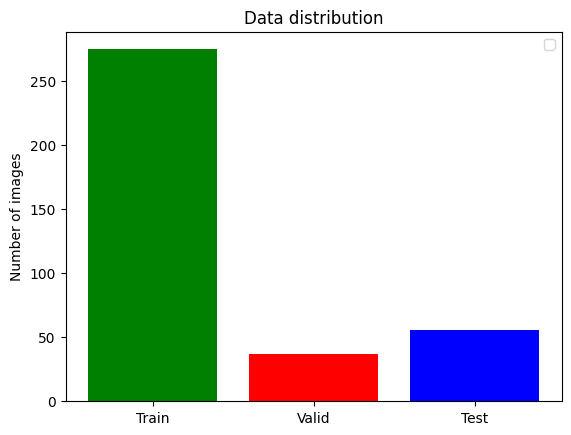

In [13]:
plt.bar(
    ["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], 
    align='center',color=[ 'green','red', 'blue']
)
plt.ylabel('Number of images')
plt.title('Data distribution')
plt.legend()
plt.show()

## Load Data

In [14]:
class SingleImageCache():
    """Cache which can store one key:value pair in memory"""
    def __init__(self):
        self.cache = {}
        self.key = None
        
    def __contains__(self, key):
        return key in self.cache
    
    def __setitem__(self, key, data):
        old_key = self.key
        if old_key is not None:
            del self.cache[old_key]
        self.cache[key] = data
        self.key = key
        
    def __getitem__(self, key):
        if key in self.cache:
            return self.cache[key]
        raise Exception(f"Key {key} not in cache")

In [15]:
class CustomDataset(Dataset):
    """On each call, returns a single slice of a brain scan"""
    def __init__(self, samples, scans=["flair"]):
        for scan in scans:
            if scan not in ["flair", "t1", "t1ce", "t2"]:
                raise Exception(f"Invalid scan: {scan}")

        self.samples = samples
        self.scans = scans
        self.n_channels = len(scans)
        self.x_shape = (self.n_channels, IMG_SIZE, IMG_SIZE) # pytorch uses channels-first
        self.y_pre_enc_shape = (IMG_SIZE, IMG_SIZE)
        self.y_one_hot_shape = (N_CLASSES, IMG_SIZE, IMG_SIZE)
        self.image_cache = SingleImageCache()  # Dictionary to cache loaded images, so subsequent requests can reuse cached images

    def __len__(self):
        return len(self.samples) * VOLUME_SLICES

    def __getitem__(self, idx):
        # idx 0 => img_idx 0
        # idx 1 => img_idx 0
        # idx 2 => img_idx 0
        # ...
        # idx 99 => img_idx 0
        # idx VOLUME_SLICES*1 => img_idx 1
        # idx VOLUME_SLICES*1+1 => img_idx 1
        # idx VOLUME_SLICES*1+2 => img_idx 1
        # ...
        # idx VOLUME_SLICES*2 => img_idx 2
        
        # get correct sample
        sample_idx = idx // VOLUME_SLICES
        slice_idx = idx % VOLUME_SLICES

        if sample_idx not in self.image_cache:
            # Load the 3D MRI image
            sample_name = self.samples[sample_idx]
            sample_path = os.path.join(DATA_DIR, sample_name)
            # Load each scan
            self.image_cache[sample_idx] = {
                scan: nib.load(os.path.join(sample_path, f'{sample_name}_{scan}.nii')).get_fdata()[:,:,VOLUME_START_AT:VOLUME_START_AT+VOLUME_SLICES]
                for scan in self.scans
            }
            # Load segmentation label
            self.image_cache[sample_idx]["seg"] = nib.load(os.path.join(sample_path, f'{sample_name}_seg.nii')).get_fdata()[:,:,VOLUME_START_AT:VOLUME_START_AT+VOLUME_SLICES]

        # get sample from cache
        sample = self.image_cache[sample_idx]
        
        # init X
        X = np.zeros(self.x_shape)
        
        # extract relevant slice from each scan
        for s, scan in enumerate(self.scans):
            scan_slice = cv2.resize(sample[scan][:,:,slice_idx], (IMG_SIZE, IMG_SIZE))
            slice_max = scan_slice.max()
            X[s,:,:] = scan_slice / slice_max if slice_max != 0 else scan_slice
            
        X = torch.tensor(X).float()
        
        # prepare label
        Y_pre_enc = cv2.resize(sample["seg"][:,:,slice_idx], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        Y_pre_enc[Y_pre_enc==4] = 3 # relabel
        Y_pre_enc = torch.tensor(Y_pre_enc.astype(np.int64))
        Y = F.one_hot(Y_pre_enc, num_classes=N_CLASSES).permute(2, 0, 1)
        
        return X, Y

In [16]:
BATCH_SIZE = 128
SCANS = ["flair", "t1"]

train_dataset = CustomDataset(samples=train_ids, scans=SCANS)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_cores, pin_memory=True)

val_dataset = CustomDataset(samples=val_ids, scans=SCANS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_cores, pin_memory=True)

test_dataset = CustomDataset(samples=test_ids, scans=SCANS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_cores, pin_memory=True)

In [17]:
for batch_idx, (data, target) in enumerate(val_dataloader):
    if batch_idx == 0:
        first_batch_data = data
        first_batch_target = target
        print(first_batch_data.shape, first_batch_target.shape)
        break

torch.Size([128, 2, 128, 128]) torch.Size([128, 4, 128, 128])


# Class weights

In [18]:
def estimate_class_weights(dataloader, n_batches=10, uniform=False):
    if uniform:
        return np.ones(N_CLASSES) / N_CLASSES

    class_weights_agg = []

    for i, (_, target_batch) in enumerate(dataloader):
        if i not in range(n_batches):
            break
        print(f"Processing batch {i+1}")
        target_batch = torch.argmax(target_batch, dim=1).view(-1)
        class_weights = compute_class_weight("balanced", classes=[0, 1, 2, 3], y=target_batch.numpy())
        class_weights_agg.append(class_weights)

    class_weights = np.mean(np.array(class_weights_agg), axis=0)
    print(f"class weights: {class_weights}")

class_weights = estimate_class_weights(train_dataloader)
class_weights

Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
class weights: [2.53746918e-01 2.39718218e+02 4.83303918e+01 2.56948712e+02]


# 2D U-Net

In [19]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, p):
        x = self.conv_transpose(x)
        x = torch.cat([x, p], dim=1)
        x = self.conv_block(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels):
        super(UNet, self).__init__()
        self.encoder1 = EncoderBlock(in_channels, 16)
        self.encoder2 = EncoderBlock(16, 32)
        self.encoder3 = EncoderBlock(32, 64)
        self.encoder4 = EncoderBlock(64, 128)
        self.encoder5 = EncoderBlock(128, 256)
        self.bridge = ConvBlock(256, 512)
        self.decoder5 = DecoderBlock(512, 256)
        self.decoder4 = DecoderBlock(256, 128)
        self.decoder3 = DecoderBlock(128, 64)
        self.decoder2 = DecoderBlock(64, 32)
        self.decoder1 = DecoderBlock(32, 16)
        self.final_conv = nn.Conv2d(16, N_CLASSES, kernel_size=1)

    def forward(self, x):
        c1, p1 = self.encoder1(x)
        c2, p2 = self.encoder2(p1)
        c3, p3 = self.encoder3(p2)
        c4, p4 = self.encoder4(p3)
        c5, p5 = self.encoder5(p4)
        bridge = self.bridge(p5)
        u5 = self.decoder5(bridge, c5)
        u4 = self.decoder4(u5, c4)
        u3 = self.decoder3(u4, c3)
        u2 = self.decoder2(u3, c2)
        u1 = self.decoder1(u2, c1)
        out = self.final_conv(u1)
        return out

In [20]:
# get input shape
input_shape = train_dataset.x_shape

# instantiate model
model = UNet(in_channels=input_shape[0])
model.to(device)

# model summary
summary(model, (input_shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             288
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,304
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
         ConvBlock-7         [-1, 16, 128, 128]               0
         MaxPool2d-8           [-1, 16, 64, 64]               0
      EncoderBlock-9  [[-1, 16, 128, 128], [-1, 16, 64, 64]]               0
           Conv2d-10           [-1, 32, 64, 64]           4,608
      BatchNorm2d-11           [-1, 32, 64, 64]              64
             ReLU-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 32, 64, 64]           9,216
      BatchNorm2d-14      

# Training

## Loss Function

In [21]:
# Dice Loss: https://github.com/hubutui/DiceLoss-PyTorch/blob/master/loss.py

def make_one_hot(input, num_classes):
    """Convert class index tensor to one hot encoding tensor.

    Args:
         input: A tensor of shape [N, 1, *]
         num_classes: An int of number of class
    Returns:
        A tensor of shape [N, num_classes, *]
    """
    shape = np.array(input.shape)
    shape[1] = num_classes
    shape = tuple(shape)
    result = torch.zeros(shape)
    result = result.scatter_(1, input.cpu(), 1)

    return result


class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))


class DiceLoss(nn.Module):
    """Dice loss, need one hot encode input
    Args:
        weight: An array of shape [num_classes,]
        ignore_index: class index to ignore
        predict: A tensor of shape [N, C, *]
        target: A tensor of same shape with predict
        other args pass to BinaryDiceLoss
    Return:
        same as BinaryDiceLoss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        predict = F.softmax(predict, dim=1)

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weight[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]

## Training loop functions

In [22]:
def run_epoch(model, dataloader, criterion, eval_model=False, log_batch_interval=20):
    if eval_model:
        model.eval()
    else:
        model.train()

    running_loss = 0.0

    for inputs, labels in tqdm.notebook.tqdm(dataloader):
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        if not eval_model:
            # Zero the parameter gradients
            optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        
        if not eval_model:
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
        
        # Print statistics
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    
    if eval_model:
        scheduler.step(running_loss)
    
    return epoch_loss

In [23]:
INIT_LR = 1e-3
DECAY_FACTOR = 0.1
PATIENCE = 3

optimizer = optim.Adam(model.parameters(), lr=INIT_LR)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=DECAY_FACTOR, patience=PATIENCE, verbose=True)

criterion = DiceLoss(weight=class_weights)

In [24]:
# Get initial losses
print(f"Initial training loss: {run_epoch(model, train_dataloader, criterion, eval_model=True)}")
print(f"Initial validation loss: {run_epoch(model, val_dataloader, criterion, eval_model=True)}")

  0%|          | 0/215 [00:00<?, ?it/s]

Initial training loss: 0.9297647304313127


  0%|          | 0/29 [00:00<?, ?it/s]

Initial validation loss: 0.9283511248128168


In [25]:
track_stats = {
    "train_loss": [],
    "val_loss": [],
}

In [26]:
num_epochs = 50

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print("Training:")
    train_loss = run_epoch(model, train_dataloader, criterion, eval_model=False)
    print(f"Training Loss: {train_loss:.4f}")
    print("Validation:")
    val_loss = run_epoch(model, val_dataloader, criterion, eval_model=True)
    print(f"Validation Loss: {val_loss:.4f}")
    
    track_stats["train_loss"].append(train_loss)
    track_stats["val_loss"].append(val_loss)

print('Finished Training')


Epoch [1/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.8264
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4955

Epoch [2/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4822
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4535

Epoch [3/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4441
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4489

Epoch [4/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4393
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4445

Epoch [5/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4368
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4450

Epoch [6/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4320
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4581

Epoch [7/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4323
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4452

Epoch [8/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4288
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4376

Epoch [9/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4285
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4393

Epoch [10/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4278
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4376

Epoch [11/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4257
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4460

Epoch [12/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4259
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4376

Epoch [13/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4257
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4351

Epoch [14/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4246
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4334

Epoch [15/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4242
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4470

Epoch [16/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4237
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4369

Epoch [17/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4221
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4337

Epoch [18/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4221
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4310

Epoch [19/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4209
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4349

Epoch [20/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4207
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4360

Epoch [21/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4209
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4348

Epoch [22/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4202
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.
Validation Loss: 0.4315

Epoch [23/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4182
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4278

Epoch [24/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4173
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4271

Epoch [25/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4169
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4268

Epoch [26/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4166
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4268

Epoch [27/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4163
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4263

Epoch [28/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4161
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4254

Epoch [29/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4159
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4257

Epoch [30/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4157
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4254

Epoch [31/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4156
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4248

Epoch [32/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4154
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4248

Epoch [33/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4152
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4247

Epoch [34/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4151
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4243

Epoch [35/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4148
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4245

Epoch [36/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4146
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4243

Epoch [37/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4145
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4244

Epoch [38/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4144
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4240

Epoch [39/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4142
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4238

Epoch [40/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4141
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4239

Epoch [41/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4140
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4240

Epoch [42/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4138
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4239

Epoch [43/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4137
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 00045: reducing learning rate of group 0 to 1.0000e-05.
Validation Loss: 0.4238

Epoch [44/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4134
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4239

Epoch [45/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4133
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4238

Epoch [46/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4132
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4238

Epoch [47/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4132
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 00049: reducing learning rate of group 0 to 1.0000e-06.
Validation Loss: 0.4239

Epoch [48/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4131
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4239

Epoch [49/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4131
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4238

Epoch [50/50]
Training:


  0%|          | 0/215 [00:00<?, ?it/s]

Training Loss: 0.4131
Validation:


  0%|          | 0/29 [00:00<?, ?it/s]

Validation Loss: 0.4238
Finished Training


# Stat Graphs

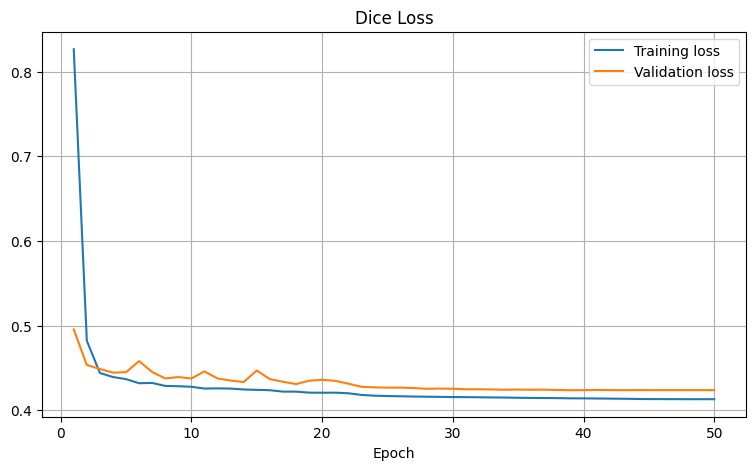

In [27]:
epochs = range(1, len(track_stats["train_loss"])+1)

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, track_stats["train_loss"], label="Training loss")
plt.plot(epochs, track_stats["val_loss"], label="Validation loss")
plt.title("Dice Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

# Evaluation

In [28]:
# Get final losses

print(f"Final training loss: {run_epoch(model, train_dataloader, criterion, eval_model=True)}")
print(f"Final validation loss: {run_epoch(model, val_dataloader, criterion, eval_model=True)}")

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch 00053: reducing learning rate of group 0 to 1.0000e-07.
Final training loss: 0.41517939470535103


  0%|          | 0/29 [00:00<?, ?it/s]

Final validation loss: 0.42384034652134467


In [29]:
def plot_predictions(data_iterator, n_slices):

    scanb, labelb = next(data_iterator)
    indices = range(len(scanb))
    
    nrows = n_slices
    ncols = 4

    plt.figure(figsize=(20, nrows*4))
    
    for r in tqdm.notebook.tqdm(range(nrows)):
        
        slice_index = random.choice(indices)
        scans = scanb[slice_index]
        label = labelb[slice_index]

        for s, scan_type in enumerate(SCANS):
            plt.subplot(nrows, ncols, r*ncols+s+1)
            plt.title(scan_type.upper())
            plt.imshow(scans[s, :, :], cmap="gray")
            plt.axis("off")

        plt.subplot(nrows, ncols, r*ncols+s+2)
        plt.title("Segmentation")
        plt.imshow(torch.argmax(label, dim=0), cmap="gray")
        plt.axis("off")

        scans = scans.to(device)
        scans = torch.unsqueeze(scans, 0)
        model.eval()
        pred = model(scans).cpu()[0]

        plt.subplot(nrows, ncols, r*ncols+s+3)
        plt.title("Prediction")
        plt.imshow(torch.argmax(pred, dim=0), cmap="gray")
        plt.axis("off")

    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

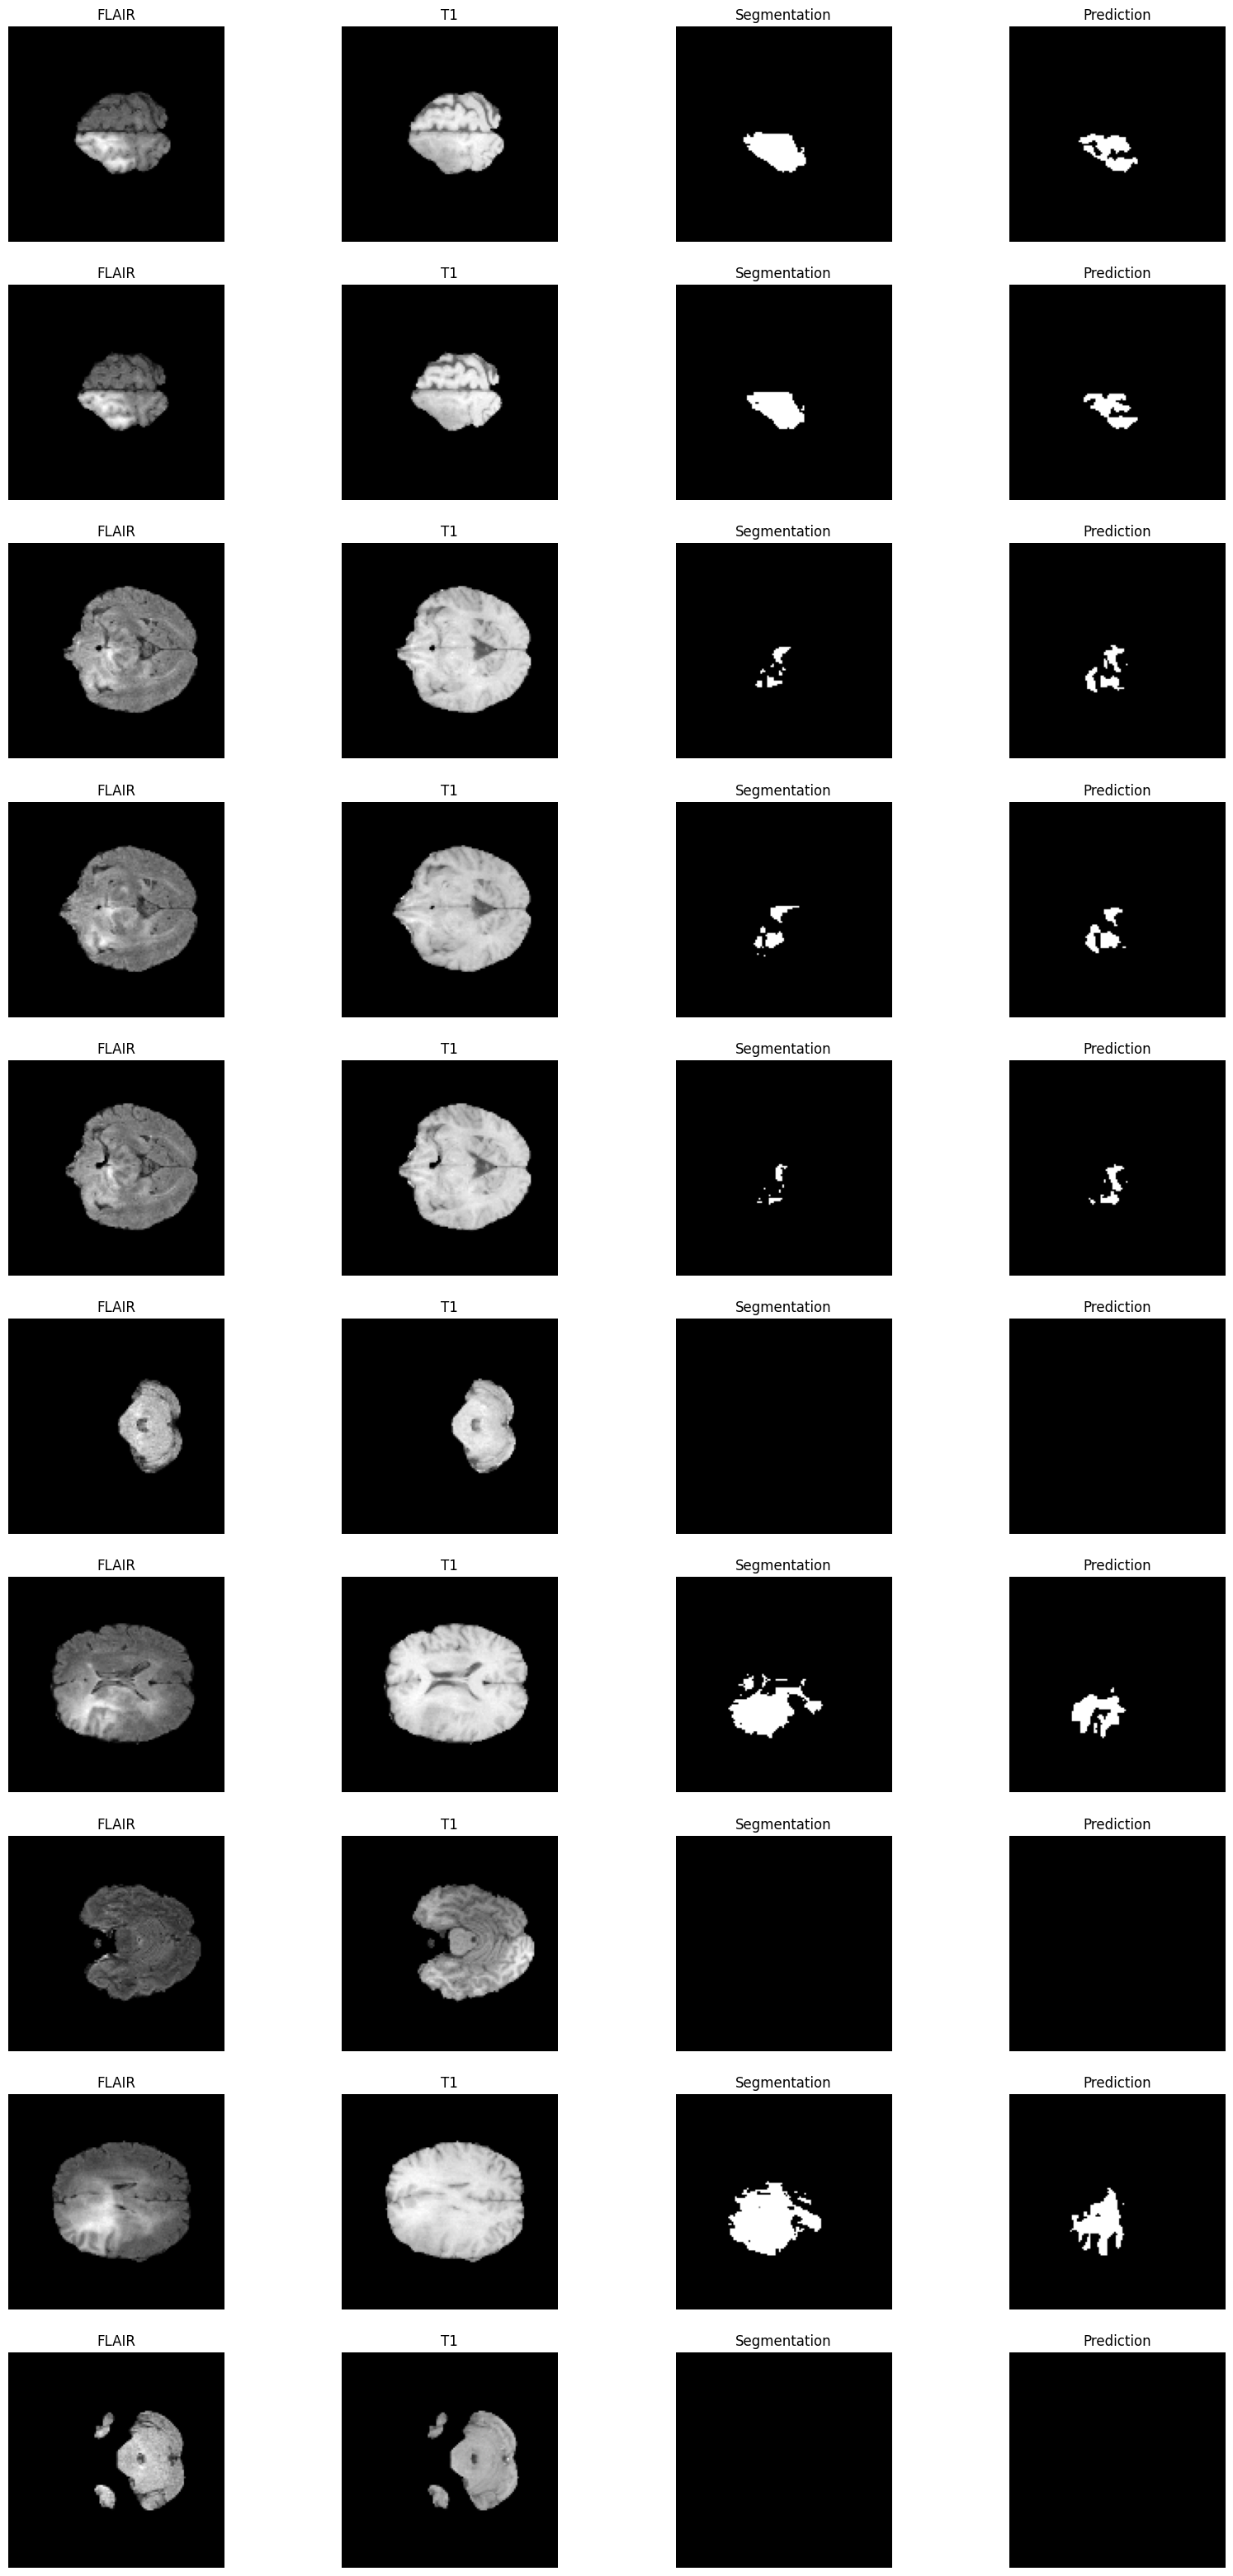

In [30]:
plot_predictions(iter(train_dataloader), n_slices=10)

  0%|          | 0/10 [00:00<?, ?it/s]

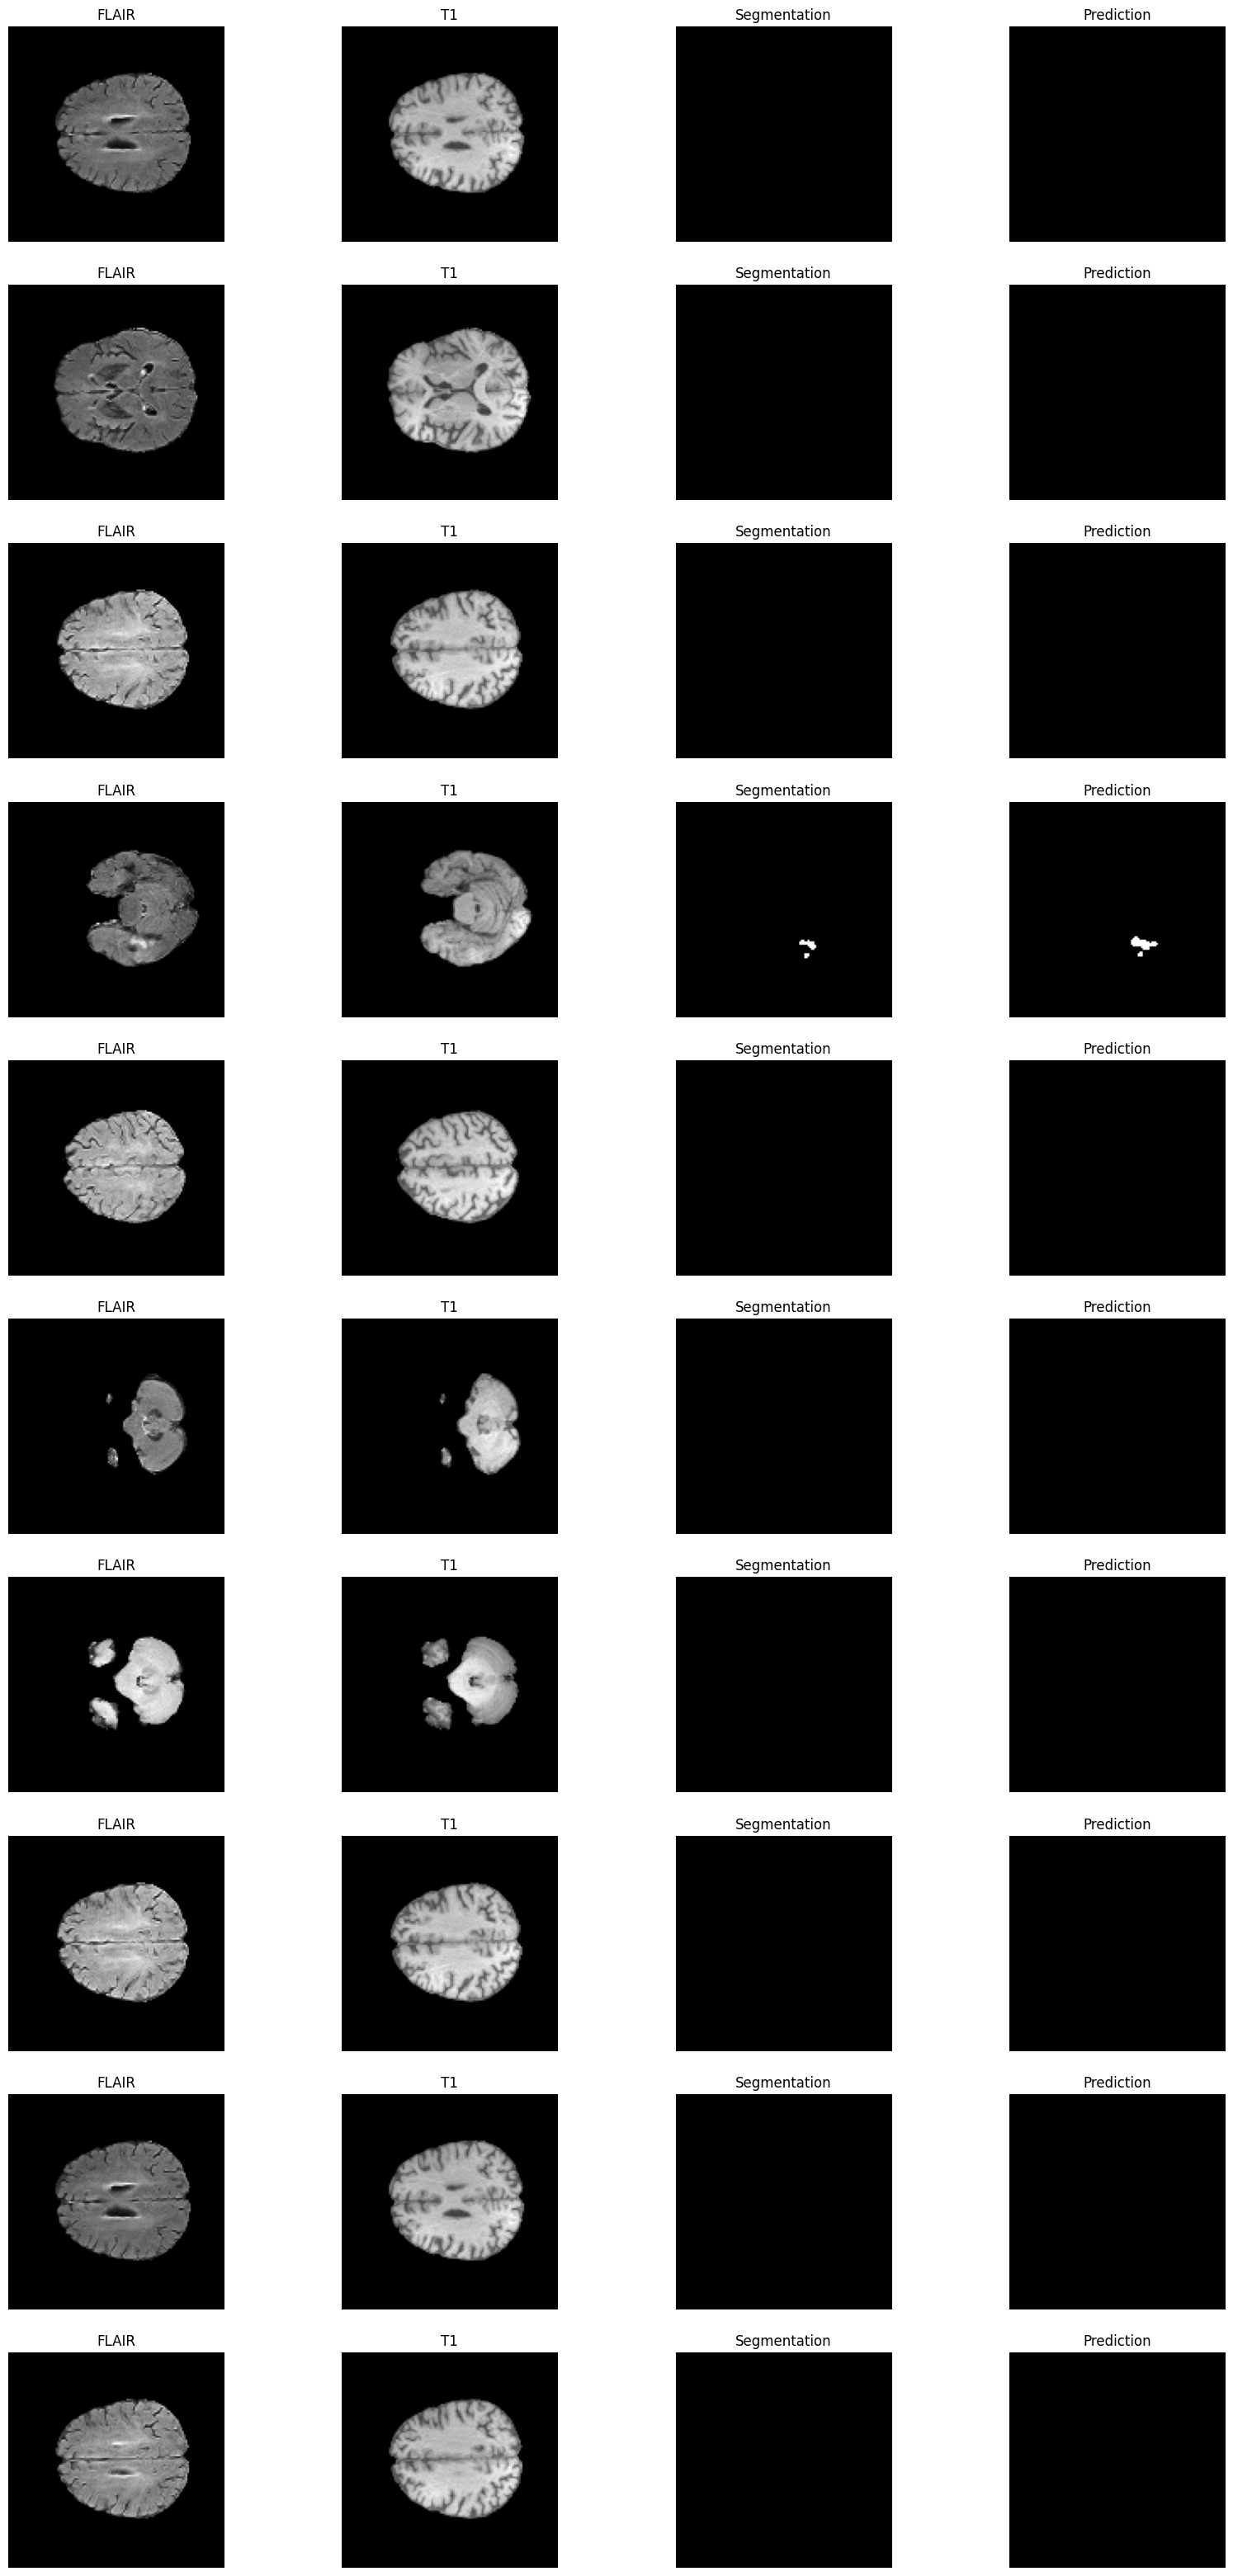

In [31]:
plot_predictions(iter(val_dataloader), n_slices=10)